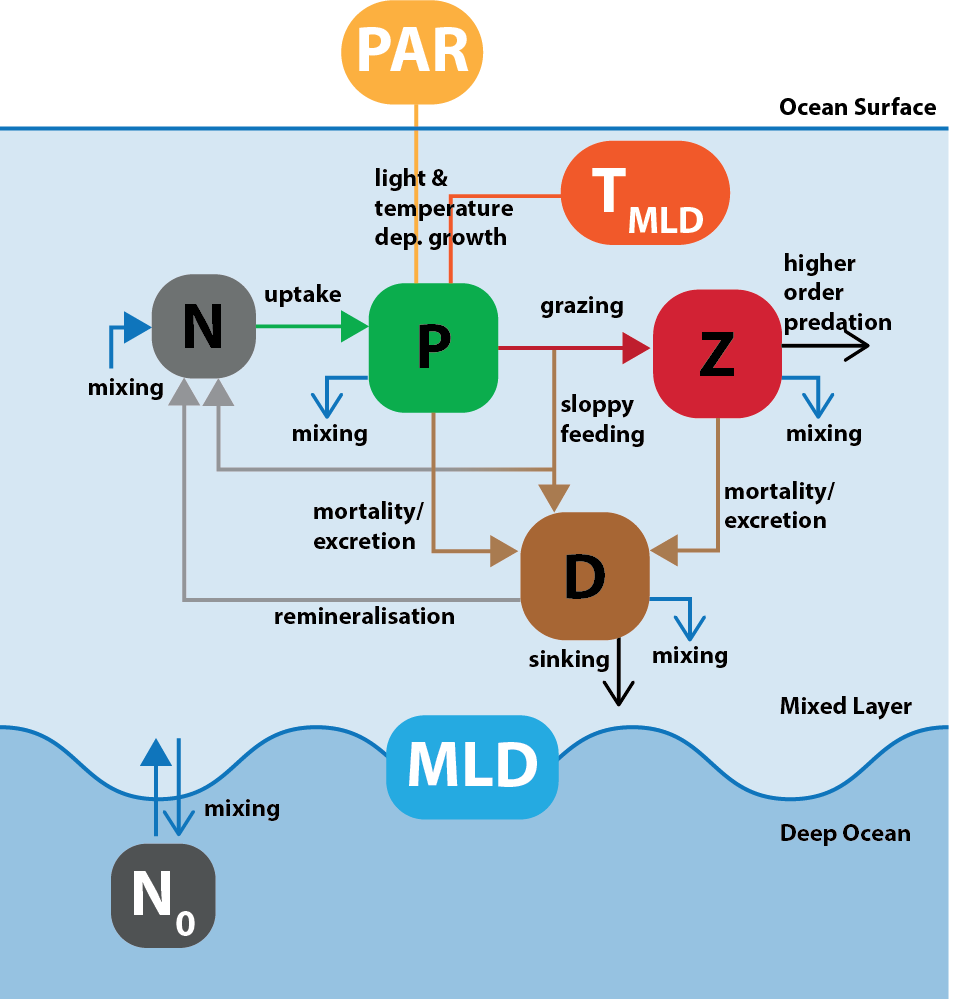

In [1]:
from IPython.display import Image
Image(filename=('NPZDslab_schematics.png'), width=500)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [5]:
from phydra.components.variables import SV

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.growth_multi_lim import Growth_ML, Eppley_ML, Monod_ML, Smith_ML
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import Mixing_K, SlabUpwelling_KfromGroup, SlabMixing_KfromGroup, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing, ConstantForcing

In [6]:
NPZD = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SV,
    'Zooplankton':SV,
    'Detritus':SV,
    
    # Mixing:
    'K':Mixing_K,
    'Upwelling':SlabUpwelling_KfromGroup,
    'Mixing':SlabMixing_KfromGroup,
    'Sinking':SlabSinking,

    # Growth
    'Growth':Growth_ML,
    'Nut_lim':Monod_ML,
    'Light_lim':Smith_ML,
    'Temp_lim':Eppley_ML,
    
    # Grazing
    'Grazing':HollingTypeIII_ResourcesListInput_Consumption2Group,
    'GGE':GrossGrowthEfficiency,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange,
    'PhytoQuadMortality':QuadraticExchange,
    'ZooLinMortality':LinearExchange,
    'HigherOrderPred':QuadraticDecay,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'N0':GlobalSlabClimatologyForcing,
    'Tmld':GlobalSlabClimatologyForcing,
    'I0':GlobalSlabClimatologyForcing,
    'MLD':GlobalSlabClimatologyForcing,
    'MLDderiv':GlobalSlabClimatologyForcing,
                     })

In [7]:
# NPZD.visualize()

In [8]:
print(NPZD)

<xsimlab.Model (27 processes, 97 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
Zooplankton
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
N0
    lat                      [in] constant value of forcing
    dataset                  [in] Options: 'n0x', 'mld', 'tmld', 'par'
    forcing_label            [in] label / 
    rbb                      [in] constant value of forcing
    k                     

('time',) (1825,)


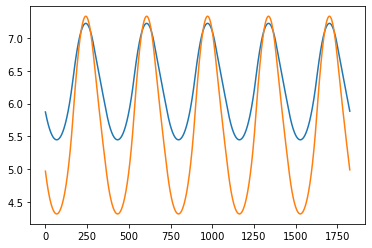

In [25]:
tdp = 2.5 * 1.066 ** temperate_out.Tmld__forcing_value

eppl = np.exp(0.12 * temperate_out.Tmld__forcing_value)
plt.plot(tdp)
plt.plot(eppl)

In [31]:
# Set common location of global slab forcing
temperate_forcing_location = {'lat':47,'lon':-20,'rbb':2}
tropical_forcing_location = {'lat':0,'lon':-20,'rbb':2}

num_years = 5

temperate_setup = phydra.setup(solver='odeint', model=NPZD,
            time=np.arange(0,365*num_years),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':.1},
                    'Zooplankton':{'var_label':'Z','var_init':.1},
                    'Detritus':{'var_label':'D','var_init':.1},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','Z','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Nut_lim':{'resource':'N', 'halfsat':.85},
                    'Light_lim':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'alpha':0.034, 'VpMax':2.5},
                    'Temp_lim':{'temp':'Tmld', 'eppley_exp':0.063},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':1., 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.015},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.025},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':0.02},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.06},

                    # Forcings
                    'N0':{**temperate_forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
                    'Tmld':{**temperate_forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
                          'smooth':5, 'k':2, 'deriv':0},
                    'I0':{**temperate_forcing_location, 'forcing_label':'I0', 'dataset':'par',
                          'smooth':10, 'k':2, 'deriv':0},
                    'MLD':{**temperate_forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':0},
                    'MLDderiv':{**temperate_forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':1}
            },
            output_vars="ALL"
            )

tropical_forcing = {
    'N0':{**tropical_forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
    'Tmld':{**tropical_forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
          'smooth':5, 'k':2, 'deriv':0},
    'I0':{**tropical_forcing_location, 'forcing_label':'I0', 'dataset':'par',
          'smooth':10, 'k':2, 'deriv':0},
    'MLD':{**tropical_forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
          'smooth':400, 'k':2, 'deriv':0},
    'MLDderiv':{**tropical_forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
          'smooth':400, 'k':2, 'deriv':1}
}

tropical_setup = temperate_setup.xsimlab.update_vars(model=NPZD, input_vars=tropical_forcing)

In [32]:
with NPZD:
    temperate_out = temperate_setup.xsimlab.run()
    tropical_out = tropical_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
Initializing component I0
Initializing component Tmld
Initializing component MLDderiv
Initializing component MLD
Initializing component K
Initializing component PhytoLinMortality
Initializing component ZooLinMortality
Initializing component Temp_lim
Initializing component Grazing
Initializing component HigherOrderPred
Initializing component Light_lim
Initializing component Nut_lim
Initializing component Sinking
Initializing component DetRemineralisation
Initializing component PhytoQuadMortality
Initializing component Upwelling
Initializing component Mixing
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x16a9d2160>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Para

# Publication Plot

In [33]:
last_year_slice = slice((num_years -1) * 365, num_years * 365)
last_year_slice

slice(1460, 1825, None)

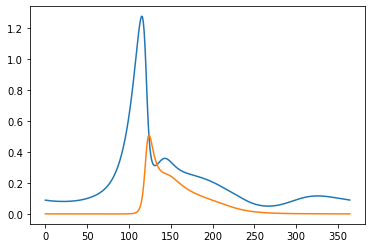

In [34]:
plt.plot(temperate_out.Phytoplankton__var_value[last_year_slice])
plt.plot(temperate_out.Zooplankton__var_value[last_year_slice])

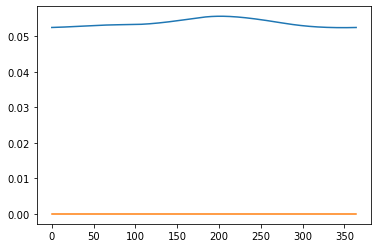

In [35]:
plt.plot(tropical_out.Phytoplankton__var_value[last_year_slice])
plt.plot(tropical_out.Zooplankton__var_value[last_year_slice])

In [36]:
from phydra.utility.forcingdata import VerifData

temperate_verif_data = VerifData(**temperate_forcing_location)
tropical_verif_data = VerifData(**tropical_forcing_location)

VerifData forcing created
VerifData forcing created


In [37]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 7]

trop_col = 'red'
temp_col = 'blue'

labels = {'model_pico':'darkgreen','model_nano':'green','model_micro':'lightgreen', 'model_nuts':'#955196','model_det':'brown','model_Z':'darkorange','data':'grey'}

culr=[temp_col,trop_col]

culrZ=['seagreen','midnightblue']

culrD=['turquoise','cornflowerblue']

culrNPZD=['#955196','green','darkorange','brown']

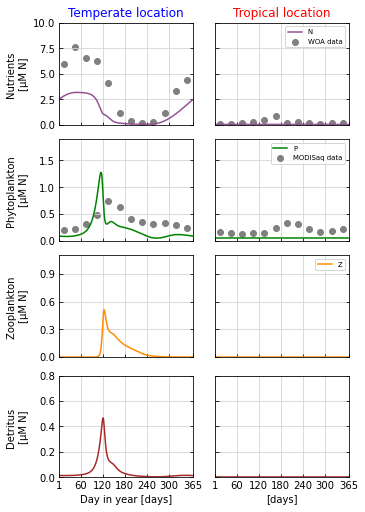

In [38]:
numcols = 2
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        
        axe[i].grid(True, color='lightgrey')
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        

# color vectors
#colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']

lws = [2, 2.5, 4, 5.5]

def modeloutputplot(i, dataset, verifdata):
    timedays_ly = dataset.Time__time[0:365]
    
    N_Max = np.max(dataset.N0__forcing_value[last_year_slice]) + np.max(dataset.N0__forcing_value[last_year_slice]) * 0.1
    #Pall = outarray_ly[:,1]    
    P_Max = 1.9 #np.max(ms.physics.forcing.verif.chla) + 0.9 * np.max(Pall)
    #Zall = outarray_ly[:,2]
    Z_Max = 1.1 #np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = 0.8 #np.max(outarray_ly[:, 3]) + 0.2 * np.max(outarray_ly[:, 3])
    
    if i == 0:
        ax1[i].set_title('Temperate location', color='blue')
    else:
        ax1[i].set_title('Tropical location', color='red')
        

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)


    # Figure 1
    # N
    ax1[i].scatter(dpm_cumsum, verifdata.N, label='WOA data', c='grey')
    ax1[i].plot(timedays_ly, dataset.Nutrient__var_value[last_year_slice], c=culrNPZD[0], label='N')
    if i == 0:
        ax1[i].set_ylabel('Nutrients \n' '[µM N]', multialignment='center', fontsize=10)
    
    ax1[i].set_ylim(0, 10)
    
    if i == 1:
        ax1[i].legend(fontsize='x-small')


    ChlConv = True
    # Phyto
    CtoChla = 75  # g/g
    MolarMassC = 12.0107
    CtoNratioPhyto = 6.625
    muMolartoChlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to

    ax2[i].scatter(dpm_cumsum, np.array(verifdata.chla) * muMolartoChlaconvfactor, label='MODISaq data', c='grey')



    ax2[i].plot(timedays_ly, dataset.Phytoplankton__var_value[last_year_slice], c=culrNPZD[1],  label='P')
    if i == 1:
        ax2[i].legend(fontsize='x-small')
        
    if i == 0:
        ax2[i].set_ylabel('Phytoplankton \n' '[µM N]', multialignment='center', fontsize=10)
    ax2[i].set_ylim(0, P_Max)
    #ax2[1].set_ylim(0, 1)
    # Z

    ax3[i].plot(timedays_ly, dataset.Zooplankton__var_value[last_year_slice], c=culrNPZD[2], label='Z')
    if i == 0:
        ax3[i].set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=10)
        ax4[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=10)
    ax3[i].tick_params('y', labelsize=10)
    ax3[i].set_ylim(0, Z_Max)
    #ax4[i_plot].set_title('Zooplankton')

    
    # D
    ax4[i].plot(timedays_ly, dataset.Detritus__var_value[last_year_slice], c=culrNPZD[3], label='D')
    #ax3[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)
    ax4[i].set_ylim(0,D_Max)
    #ax3[1].set_ylim(0,0.1)
    ax4[0].set_xlabel('Day in year [days]')
    ax4[1].set_xlabel('[days]')
    if i == 1:
        ax3[i].legend(fontsize='x-small')
        ax1[i].set_yticklabels([])
        ax2[i].set_yticklabels([])
        ax3[i].set_yticklabels([])
        ax4[i].set_yticklabels([])
    # Legend

    
    
modeloutputplot(0, temperate_out, temperate_verif_data)
modeloutputplot(1, tropical_out, tropical_verif_data)
# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax1, ax2, ax3), xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

#plt.savefig('../02_NPZDslab.pdf', bbox_inches='tight')
plt.show()

# analytics

In [11]:
last_year_slice = slice((num_years -1) * 365, num_years * 365)
last_year_slice

slice(1460, 1825, None)

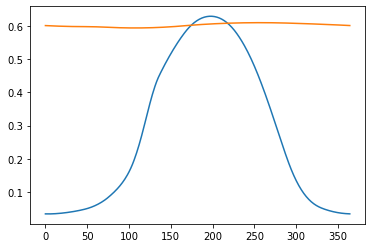

In [12]:
plt.plot(temperate_out.Light_lim__smith_light_lim_value[last_year_slice])
plt.plot(tropical_out.Light_lim__smith_light_lim_value[last_year_slice])

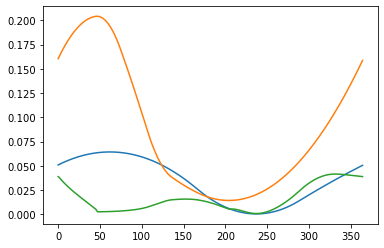

In [13]:
plt.plot(temperate_out.N0__forcing_value[last_year_slice]/100)

plt.plot(temperate_out.MLD__forcing_value[last_year_slice]/1000)

plt.plot(temperate_out.Upwelling__mixing_value[last_year_slice])

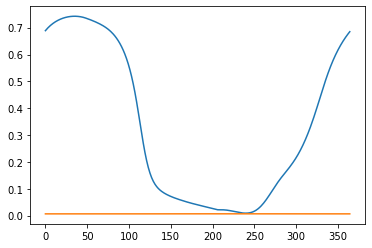

In [14]:
plt.plot(temperate_out.Nut_lim__monod_lim_value[last_year_slice])
plt.plot(tropical_out.Nut_lim__monod_lim_value[last_year_slice])

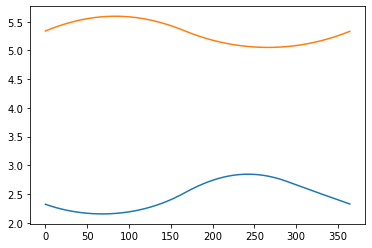

In [15]:
plt.plot(temperate_out.Temp_lim__eppley_growth_value[last_year_slice])
plt.plot(tropical_out.Temp_lim__eppley_growth_value[last_year_slice])

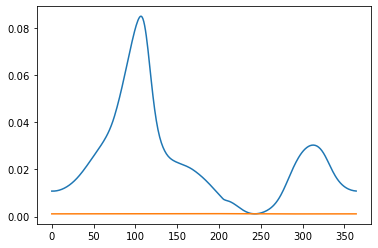

In [16]:
plt.plot(temperate_out.Growth__growth_value[last_year_slice])
plt.plot(tropical_out.Growth__growth_value[last_year_slice])

# TEMPERATE FORCING

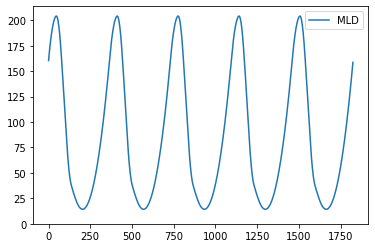

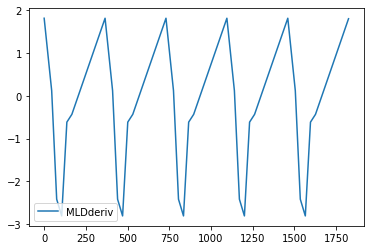

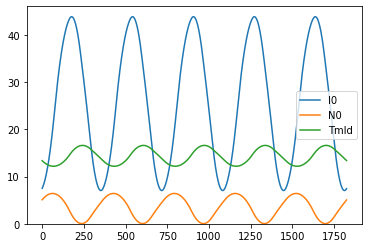

In [11]:
time = temperate_out.Time__time

plt.plot(time, temperate_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, temperate_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, temperate_out.I0__forcing_value, label='I0')
plt.plot(time, temperate_out.N0__forcing_value, label='N0')
plt.plot(time, temperate_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

# TROPICAL FORCING

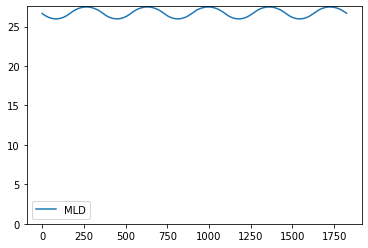

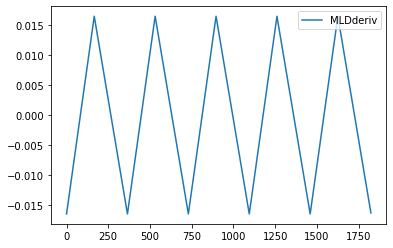

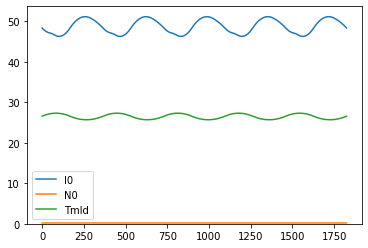

In [12]:
time = tropical_out.Time__time

plt.plot(time, tropical_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, tropical_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, tropical_out.I0__forcing_value, label='I0')
plt.plot(time, tropical_out.N0__forcing_value, label='N0')
plt.plot(time, tropical_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()